## Telecom Customer Churn:
     Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

#### Content:
     Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

#### The data set includes information about:

   * Customers who left within the last month – the column is called Churn
   * Services that each customer has signed up for – phone, multiple lines, internet, online        * security, online backup, device protection, tech support, and streaming TV and movies
   * Customer account information – how long they’ve been a customer, contract, payment method,
   * paperless billing, monthly charges, and total charges
   * Demographic info about customers – gender, age range, and if they have partners and dependents
   * Churn - dependent feature ('Yes' denotes customers left, 'No' denotes customer stay here)
   
  
     

In [117]:
# Importing neccessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectKBest
from collections import Counter

# ignore warning
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick # for showing percentage in it

In [118]:
try:
    # Trying to open the XLSX file with openpyxl
  data = pd.read_excel('customer_churn_large_dataset.xlsx')
except ImportError:
    # If openpyxl is not available, use the xlrd engine
   data = pd.read_excel('customer_churn_large_dataset.xlsx', engine='xlrd')

# Now we can work with the DataFrame 'df' using Pandas


In [119]:
data.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [120]:
# Features types
data.dtypes

CustomerID                      int64
Name                           object
Age                             int64
Gender                         object
Location                       object
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Churn                           int64
dtype: object

#### **From analysis the dataset, we notice that some of the independent features are in numerical and most of feature are in categorical feature. Seperate into numerical and categorical data for EDA parts**

In [121]:
# Total charges are in object dtype so convert into Numerical feature
data['Monthly_Bill'] = pd.to_numeric(data['Monthly_Bill'], errors='coerce')

#### Separate into Numerical and Categorical feature

In [122]:
# numerical feature
numerical_feature = {feature for feature in data.columns if data[feature].dtypes != 'O'}
print(f'Count of Numerical feature: {len(numerical_feature)}')
print(f'Numerical feature are:\n {numerical_feature}')

Count of Numerical feature: 6
Numerical feature are:
 {'Total_Usage_GB', 'Age', 'Subscription_Length_Months', 'Churn', 'CustomerID', 'Monthly_Bill'}


In [123]:
# Categorical feature
categorical_feature = {feature for feature in data.columns if data[feature].dtypes == 'O'}
print(f'Count of Categorical feature: {len(categorical_feature)}')
print(f'Categorical feature are:\n {categorical_feature}')

Count of Categorical feature: 3
Categorical feature are:
 {'Location', 'Name', 'Gender'}


## EDA

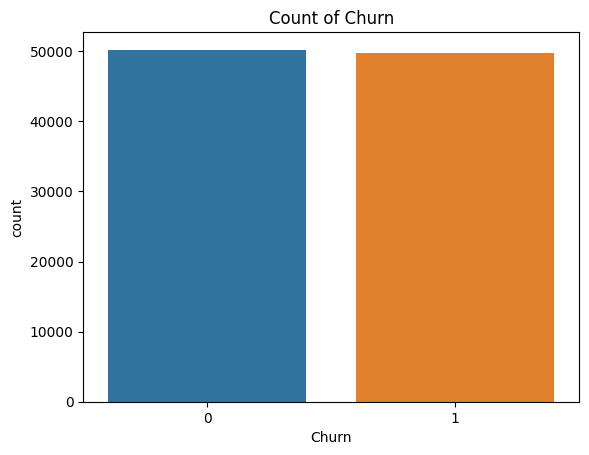

In [124]:
# plotting with target feature
sns.countplot(data=data, x='Churn')
plt.title('Count of Churn')
plt.show()

In [125]:
l1 = data.loc[data['Churn']== 'Yes'].count()[0]
print(f"Pecentage of Left: {l1/len(data['Churn'])}")
print(data.Churn.value_counts())

Pecentage of Left: 0.0
0    50221
1    49779
Name: Churn, dtype: int64


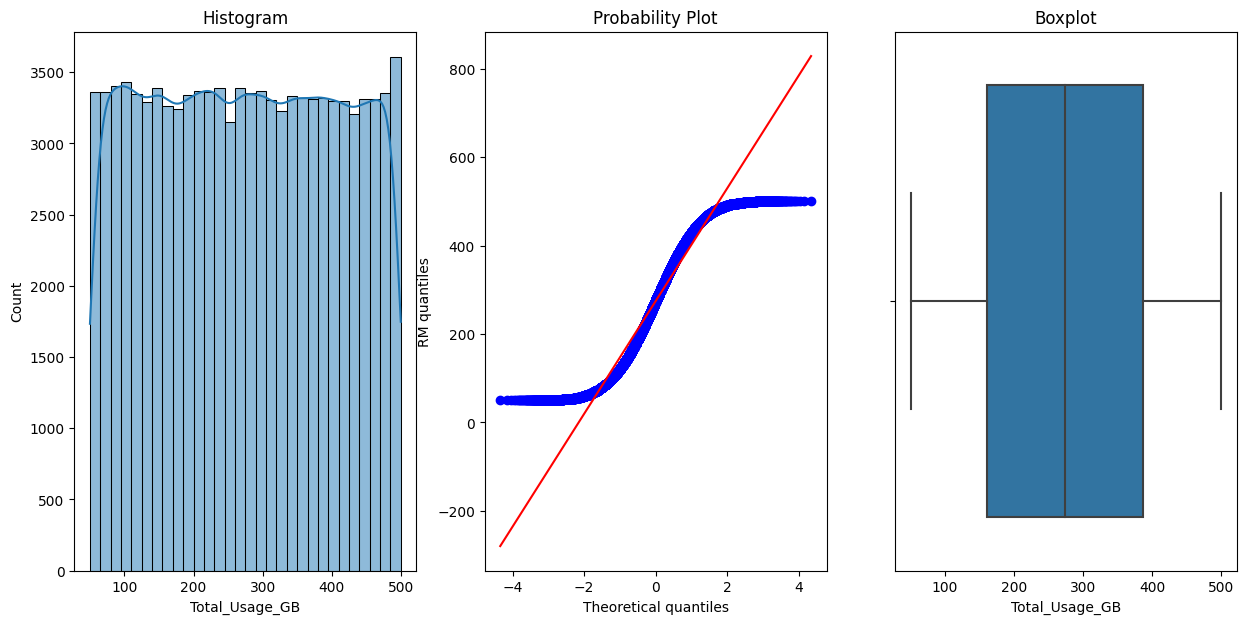

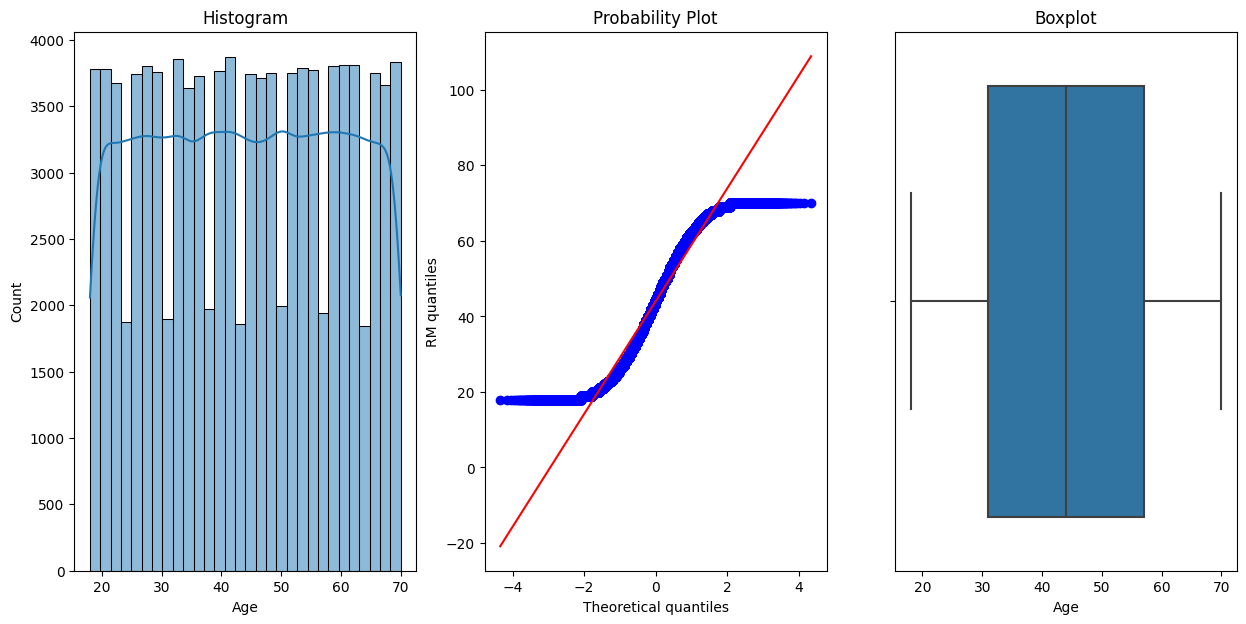

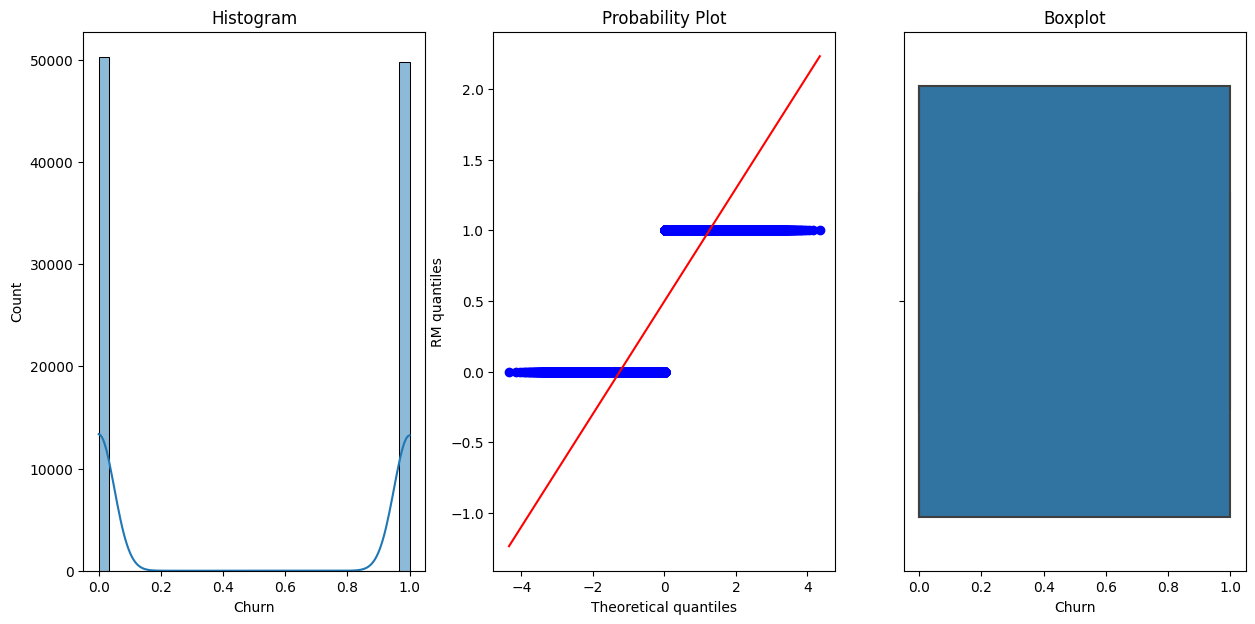

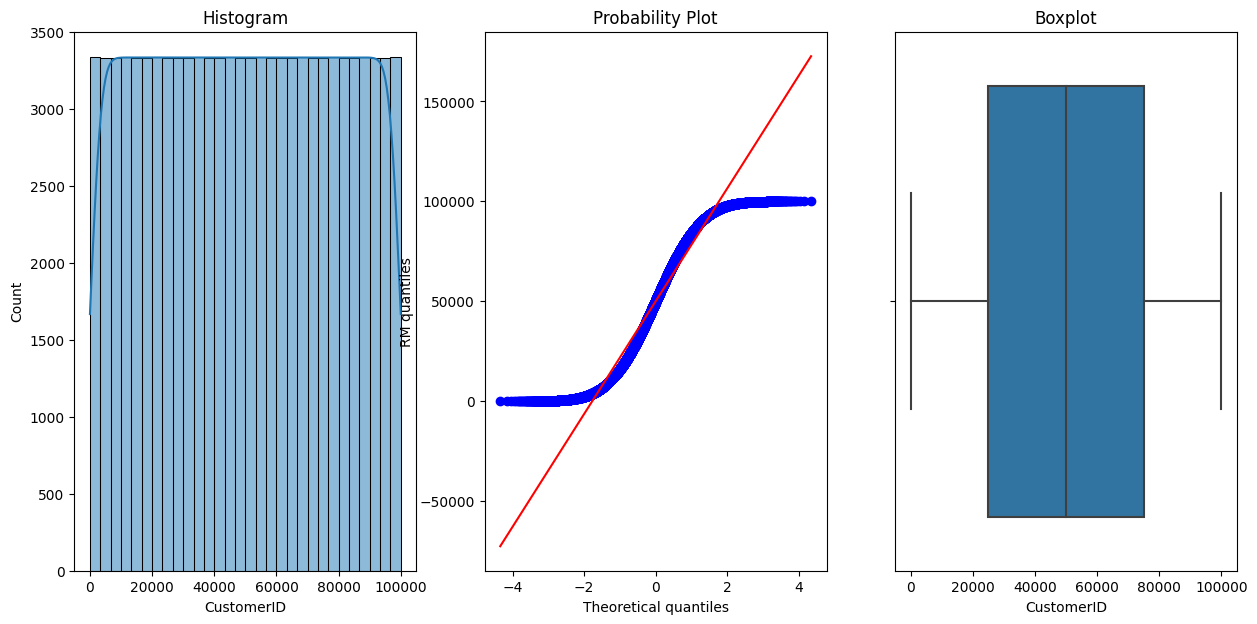

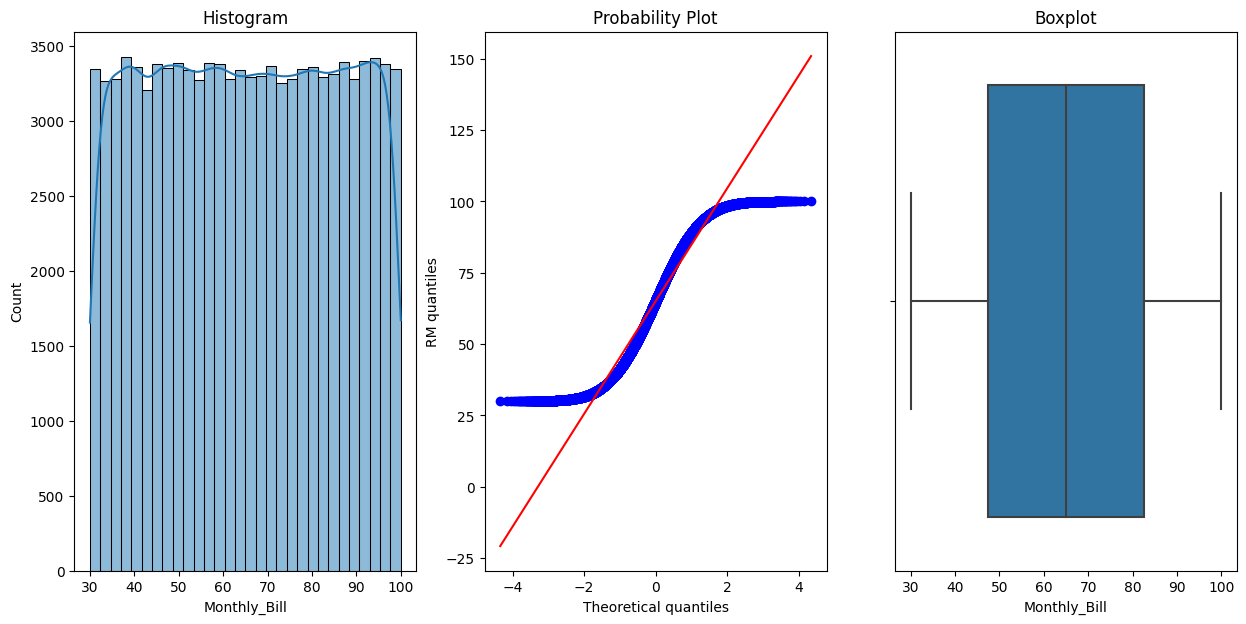

In [126]:
### Plotting numerical feature with probability distribution and checking outlier
for feature in numerical_feature:
    if feature != 'Subscription_Length_Months':
        plt.figure(figsize=(15,7))

        plt.subplot(1, 3, 1)
        sns.histplot(data=data, x=feature, bins=30, kde=True)
        plt.title('Histogram')

        plt.subplot(1, 3, 2)
        stats.probplot(data[feature], dist="norm", plot=plt)
        plt.ylabel('RM quantiles')

        plt.subplot(1, 3, 3)
        sns.boxplot(x=data[feature])
        plt.title('Boxplot')

plt.show()

##### **After ploting histogram probability distribution and box plot to find numerical value are in normally distribution and our dataset has no outlier dataset.So, we don't want to remove the outlier in our dataset**

#### **Data Cleaning:**

In [127]:
data.isnull().sum()

CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

In [128]:
# replace NaN values with mean value
data.Monthly_Bill = data.Monthly_Bill.fillna(data.Monthly_Bill.median())

<Axes: >

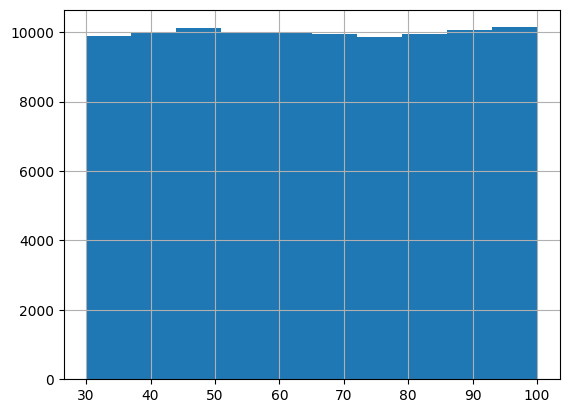

In [129]:
data.Monthly_Bill.hist()

##### **In this dataset there is no null values, so we dont want to perform Handling missing values. Only perform the Feature Encoding techiniques to convert the categorical feature into numerical feature**

In [130]:
print(categorical_feature)

{'Location', 'Name', 'Gender'}


In [131]:
encoder = LabelEncoder()
for feature in categorical_feature:
    data[feature] = encoder.fit_transform(data[feature])

In [132]:
data.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,0,63,1,2,17,73.36,236,0
1,2,11112,62,0,4,1,48.76,172,0
2,3,22223,24,0,2,5,85.47,460,0
3,4,33334,36,0,3,3,97.94,297,1
4,5,44445,46,0,3,19,58.14,266,0


In [133]:
data.drop(columns=['CustomerID'], inplace=True)

<Axes: >

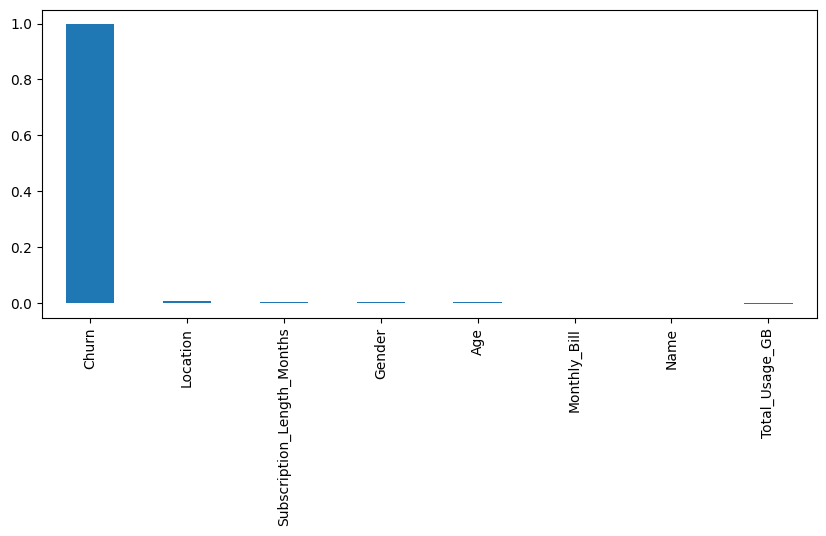

In [134]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(10,4))
data.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

<Axes: >

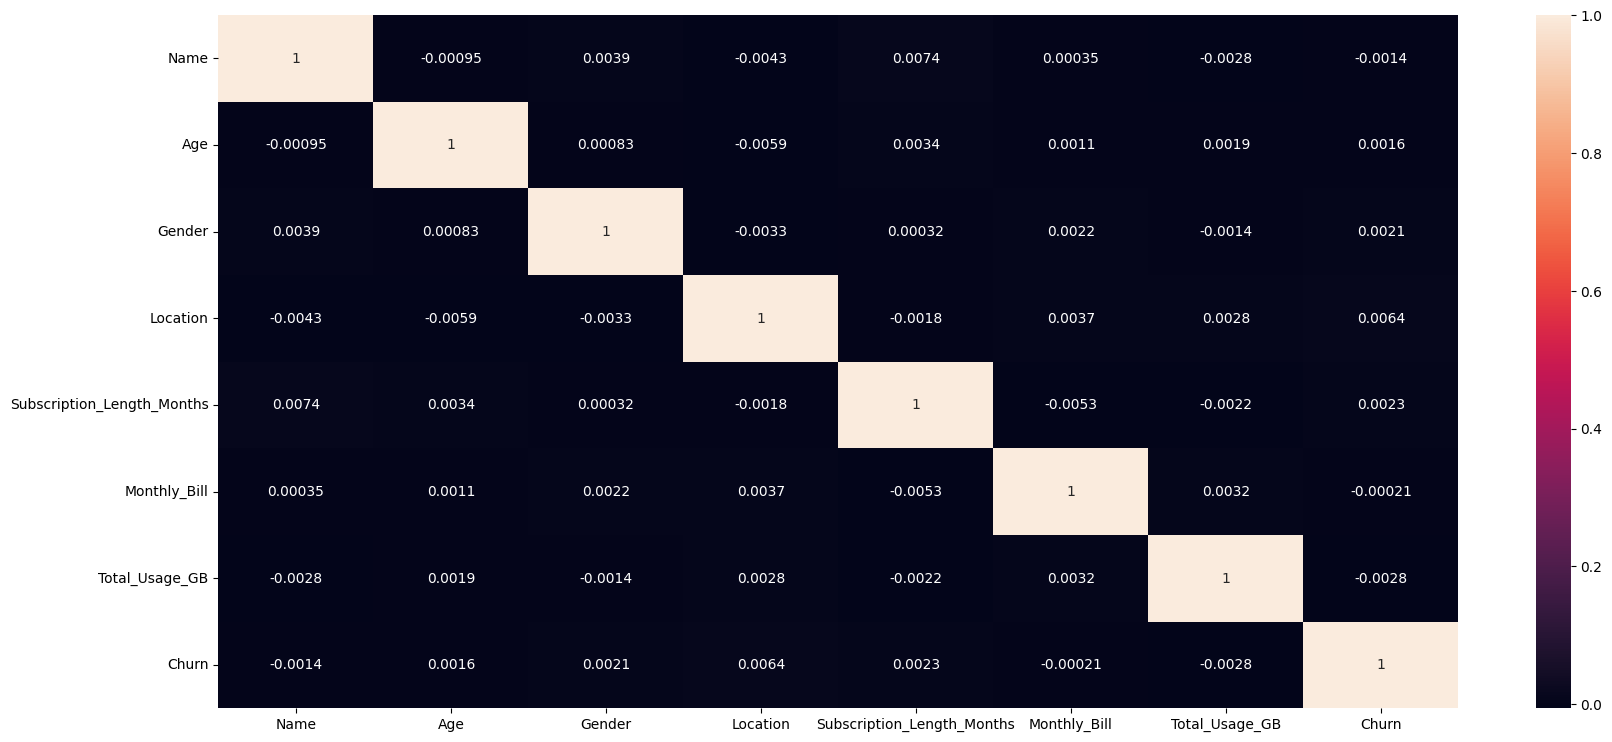

In [135]:
# Finding the correlation between the independent and dependent feature
plt.figure(figsize=(20, 9))
sns.heatmap(data.corr(), annot=True)

**Iam using ensemble methods, No need to perform feature scaling for ensemble techniques, its prediction based on the creating multiple decision trees**

#### Splitting the dataset into train and test

In [136]:
# splitting dataset into dependent and independent feature
X = data.drop(columns='Churn')
y = data['Churn']

In [137]:
X.head()

,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB
0,0,63,1,2,17,73.36,236
1,11112,62,0,4,1,48.76,172
2,22223,24,0,2,5,85.47,460
3,33334,36,0,3,3,97.94,297
4,44445,46,0,3,19,58.14,266


#### Feature Selection:
     Selects only 10 feature which has higher correlation

In [138]:
from sklearn.feature_selection import SelectKBest, f_classif  # Import the appropriate scoring function for your problem

k = 5

# Create the SelectKBest instance with the scoring function
selection = SelectKBest(score_func=f_classif, k=k)

# Fit and transform your data
X= selection.fit_transform(X, y)


In [139]:
#  this will shows which feature are taken denote as True other are removed like false
selection.get_support()

array([False,  True,  True,  True,  True, False,  True])

##### **From sklearn using feature selection modules importing the SelectKBest to select the important feature**

In [140]:
# splitting for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [141]:
X_train.shape

(80000, 5)

In [142]:
X_test.shape

(20000, 5)

In [143]:
# its an imbalance dataset
y.value_counts()

0    50221
1    49779
Name: Churn, dtype: int64

#### **Apply into machine learning algorithm:**

In [144]:
Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.50475
Confusion matrix :
 [[5781 5538]
 [4367 4314]]
Classification report :
               precision    recall  f1-score   support

           0       0.57      0.51      0.54     11319
           1       0.44      0.50      0.47      8681

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.51      0.50      0.51     20000



In [145]:
# Random forest classifier
Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.5003
Confusion matrix :
 [[5271 5117]
 [4877 4735]]
Classification report :
               precision    recall  f1-score   support

           0       0.52      0.51      0.51     10388
           1       0.48      0.49      0.49      9612

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [146]:
# decisionTree Classifier
Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.49775
Confusion matrix :
 [[5319 5216]
 [4829 4636]]
Classification report :
               precision    recall  f1-score   support

           0       0.52      0.50      0.51     10535
           1       0.47      0.49      0.48      9465

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



**As we can see the imbalance dataset our model doesn't perform well enough to build an end to end project. So we need to use over smpling data for reducing the TN, FN and increase the FP and TP for model building**

### **Using SMOTEENN for imbalance dataset:**
     Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [147]:
st=SMOTEENN()
X_train_st,y_train_st = st.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 40073, 1: 39927})
The number of classes after fit Counter({1: 5040, 0: 4931})


In [148]:
# splitting the over sampling dataset
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [149]:
# decisionTree Classifier
Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.5358395989974938
Confusion matrix :
 [[528 445]
 [481 541]]
Classification report :
               precision    recall  f1-score   support

           0       0.52      0.54      0.53       973
           1       0.55      0.53      0.54      1022

    accuracy                           0.54      1995
   macro avg       0.54      0.54      0.54      1995
weighted avg       0.54      0.54      0.54      1995



In [150]:
# Random forest classifier
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.6215538847117794
Confusion matrix :
 [[584 330]
 [425 656]]
Classification report :
               precision    recall  f1-score   support

           0       0.58      0.64      0.61       914
           1       0.67      0.61      0.63      1081

    accuracy                           0.62      1995
   macro avg       0.62      0.62      0.62      1995
weighted avg       0.63      0.62      0.62      1995



In [151]:
# logistic regression
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.4992481203007519
Confusion matrix :
 [[352 342]
 [657 644]]
Classification report :
               precision    recall  f1-score   support

           0       0.35      0.51      0.41       694
           1       0.65      0.50      0.56      1301

    accuracy                           0.50      1995
   macro avg       0.50      0.50      0.49      1995
weighted avg       0.55      0.50      0.51      1995



In [152]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_sap, y_train_sap)
pred = gbc.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.5588972431077694
Confusion matrix :
 [[518 389]
 [491 597]]
Classification report :
               precision    recall  f1-score   support

           0       0.51      0.57      0.54       907
           1       0.61      0.55      0.58      1088

    accuracy                           0.56      1995
   macro avg       0.56      0.56      0.56      1995
weighted avg       0.56      0.56      0.56      1995



**After using SMOOTEENN methods to perform over sampling and down sampling with edited nearest neighbours. From this results we get better accuraccy and TP FP ratio also increases in GradientBoostClassifier so perform HyperParameter Tunning for this model only**

In [153]:
param_grid = {'n_estimators':[100, 150, 200, 250, 300],
             'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
             'min_samples_split': [2,3,4,5,6,7,8,9,10],
             'min_samples_leaf': [1,3,5,7,9,11,13,15],'max_leaf_nodes': [3,6,8,9,12,15,18,24],
              'max_depth': [3,5,7,9,11,13,15,17,19],
              'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'loss': ['deviance', 'exponential']
              }

In [ ]:
gbc_optm = RandomizedSearchCV(estimator=gbc, param_distributions=param_grid,n_iter=100, verbose=3)
gbc_optm.fit(X_train_sap, y_train_sap)

In [155]:
gbc_optm.best_estimator_

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.5,
                           loss='deviance', max_depth=19, max_leaf_nodes=24,
                           min_samples_leaf=5, min_samples_split=8,
                           n_estimators=300)

In [156]:
# GradientBoostingClassifier
gbc_tunning = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.3,
                           max_depth=19, max_leaf_nodes=24, min_samples_leaf=9,
                           min_samples_split=7, n_estimators=150)
gbc_tunning.fit(X_train_sap, y_train_sap)
pred = gbc_tunning.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.6832080200501253
Confusion matrix :
 [[666 289]
 [343 697]]
Classification report :
               precision    recall  f1-score   support

           0       0.66      0.70      0.68       955
           1       0.71      0.67      0.69      1040

    accuracy                           0.68      1995
   macro avg       0.68      0.68      0.68      1995
weighted avg       0.68      0.68      0.68      1995



**After Oversampling the dataset our model performs pretty good. Our 4 models of GradientBoostClassifier performs better than all. So now we dump our model using pickle library**

## <h3>Cross-Validation:</h3>
Cross-validation is a technique for assessing the performance of a machine learning model more robustly than a single train-test split. You can use cross-validation to estimate the model's performance on different subsets of the data. One common method is k-fold cross-validation. Here's how you can use it:

In [157]:
from sklearn.model_selection import cross_val_score

# Define your GradientBoostingClassifier with the chosen hyperparameters
gbc_tuning = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.3,
                                        max_depth=19, max_leaf_nodes=24, min_samples_leaf=9,
                                        min_samples_split=7, n_estimators=150)

# Perform 5-fold cross-validation (you can adjust the number of folds as needed)
scores = cross_val_score(gbc_tuning, X_train_sap, y_train_sap, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Scores: [0.68358396 0.68840125 0.66708464 0.64075235 0.67836991]
Mean Accuracy: 0.6716384220739938


<h3>Hyperparameter Tuning:</h3>
Hyperparameter tuning involves finding the best set of hyperparameters for your model to improve its performance. You can use techniques like Grid Search or Random Search to find the optimal hyperparameters. Here's an example using Grid Search:

In [158]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search over
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5],
    'max_depth': [10, 15, 20],
    'n_estimators': [100, 150, 200]
}

# Create a GridSearchCV object with your classifier and parameter grid
grid_search = GridSearchCV(GradientBoostingClassifier(criterion='squared_error', min_samples_leaf=9, min_samples_split=7, max_leaf_nodes=24),
                           param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your training data
grid_search.fit(X_train_sap, y_train_sap)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Get the best classifier from the grid search
best_gbc = grid_search.best_estimator_

# Evaluate the best classifier on the test data
pred = best_gbc.predict(X_test_sap)
accuracy = accuracy_score(pred, y_test_sap)
print(f'Test Accuracy: {accuracy}')


Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 200}
Best Accuracy: 0.6806653781789898
Test Accuracy: 0.6832080200501253


#### **Model Saving:**

In [159]:
import pickle

In [160]:
filename = 'Model.save'
pickle.dump(gbc_tunning, open(filename,'wb'))

In [161]:
load_model = pickle.load(open(filename, 'rb'))

In [162]:
load_model.score(X_test_sap, y_test_sap)

0.6832080200501253

In [167]:
data

,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,0,63,1,2,17,73.36,236,0
1,11112,62,0,4,1,48.76,172,0
2,22223,24,0,2,5,85.47,460,0
3,33334,36,0,3,3,97.94,297,1
4,44445,46,0,3,19,58.14,266,0
...,...,...,...,...,...,...,...,...
99995,99996,33,1,1,23,55.13,226,1
99996,99997,62,0,4,19,61.65,351,0
99997,99998,64,1,0,17,96.11,251,1
99998,99999,51,0,4,20,49.25,434,1


In [169]:
Name =''
Age	=''
Gender =''
Location =''
Subscription_Length_Months =''
Monthly_Bill	=''
Total_Usage_GB	=''
Churn =''

In [181]:
data = [[Location,	Subscription_Length_Months,	Monthly_Bill,	Total_Usage_GB,	Churn]]

In [182]:
df = pd.DataFrame(data, columns=['Location','Subscription_Length_Months','Monthly_Bill','Total_Usage_GB','Churn'])
df.head()
print(df.dtypes)

Location                      object
Subscription_Length_Months    object
Monthly_Bill                  object
Total_Usage_GB                object
Churn                         object
dtype: object


In [183]:
for feature in df.columns:
    if df[feature].dtypes == 'O':
        categorical_feature = feature
        print(categorical_feature)

Location
Subscription_Length_Months
Monthly_Bill
Total_Usage_GB
Churn


In [184]:
encoder = LabelEncoder()
for feature in df.columns:
    if df[feature].dtypes == 'O':
        df[feature] = encoder.fit_transform(df[feature])

In [185]:
df.head()

,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,0,0,0,0,0


In [186]:
single = load_model.predict(df)
probability = load_model.predict_proba(df)[:,1]

In [187]:
print(single)

[0]


In [188]:
print(probability)

[0.12056717]


In [189]:
if single == 1:
    print("This Customer is likely to Churn!")
    print(f"Confidence level is {np.round(probability*100, 2)}")
else:
    print("This Customer is likely to Continue!")
    print(f"Confidence level is {np.round(probability*100, 2)}")

This Customer is likely to Continue!
Confidence level is [12.06]
